# Use Convolutional Neural Network to Identify Spiral Arms
Model 3a:  binary classification.  Model overfit.

A vanilla CNN model to classify 2 classes: spiral and other types (no spiral features)....
--
Motivation: my astrophysical research in the past three years focused on understanding the origin of spiral arms.
Our solar system and the only home that we know reside on a spiral arm of the Milky Way galaxy. 
My research looks back in time and captures spiral arms in their earliest stage of formation. 

How do we know if a galaxy has spiral arms?  The definition of spirals arms is unfortunately visual and subject to 
human being's perceptions. Detecting the existence of spiral arms in galaxies is not that much different from detecting
cats in social media images.  I have always wondered about whether machine learning algorithms can help
us find and identify spiral galaxies automatically among millions of astronomical images. Astronomers are beginning 
to  use ML for galaxy morphology classification, with varying degrees of successes depending on the specific problem.

Here is my first attempt of building a vanilla CNN using Tensorflow to address the simple question of spiral or non-spiral. 
The ultimate goal is to find a model (and dataset) that can offer second opinions and fast-track spiral structure detection
in distant galaxies.

Preparing good training and testing datasets is where the domain knowledge about galaxies help greatly. As I only care about 
spiral structures, I construct 3 classes (spiral, non-spiral-early-type, non-spiral-other-types) from the raw dataset provided on Kaggle. 
For  descriptions about the dataset, see group_data.ipynb.   This notebook describes the architecture and model performances.
I am going to experiment with models trained with different datasets, so see model*.ipynb for  outcomes of different experiments.

---
The most helpful courses that I have taken on machine learning are Andrew Ng's courses on coursera. Here 
is a link to his course on CNN:
https://www.coursera.org/learn/convolutional-neural-networks


### Importing the libraries

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

## Part 1 - Data Preprocessing
### Preprocessing the Training set

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size = (100, 100),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 20020 images belonging to 2 classes.


### Preprocessing the Test set

In [3]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6132 images belonging to 2 classes.


## Building the CNN

### Initialising the CNN

In [4]:
cnn = tf.keras.models.Sequential()

### Convolution

In [5]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[100, 100, 3]))

### Pooling

In [6]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolution + pooling layer

In [7]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Flattening

In [8]:
cnn.add(tf.keras.layers.Flatten())

### Full Connection

In [9]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Output Layer

In [10]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the CNN

### Compiling the CNN

In [11]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2166912   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

### Training the CNN on the Training set and evaluating it on the Test set

In [13]:
from tensorflow import keras
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

#### add visualisation
* code block here adapted from https://github.com/kapil-varshney/utilities/blob/master/training_plot/training_plot_ex_with_cifar10.ipynb

In [14]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn-talk")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_accuracy")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
plot_losses = TrainingPlot()

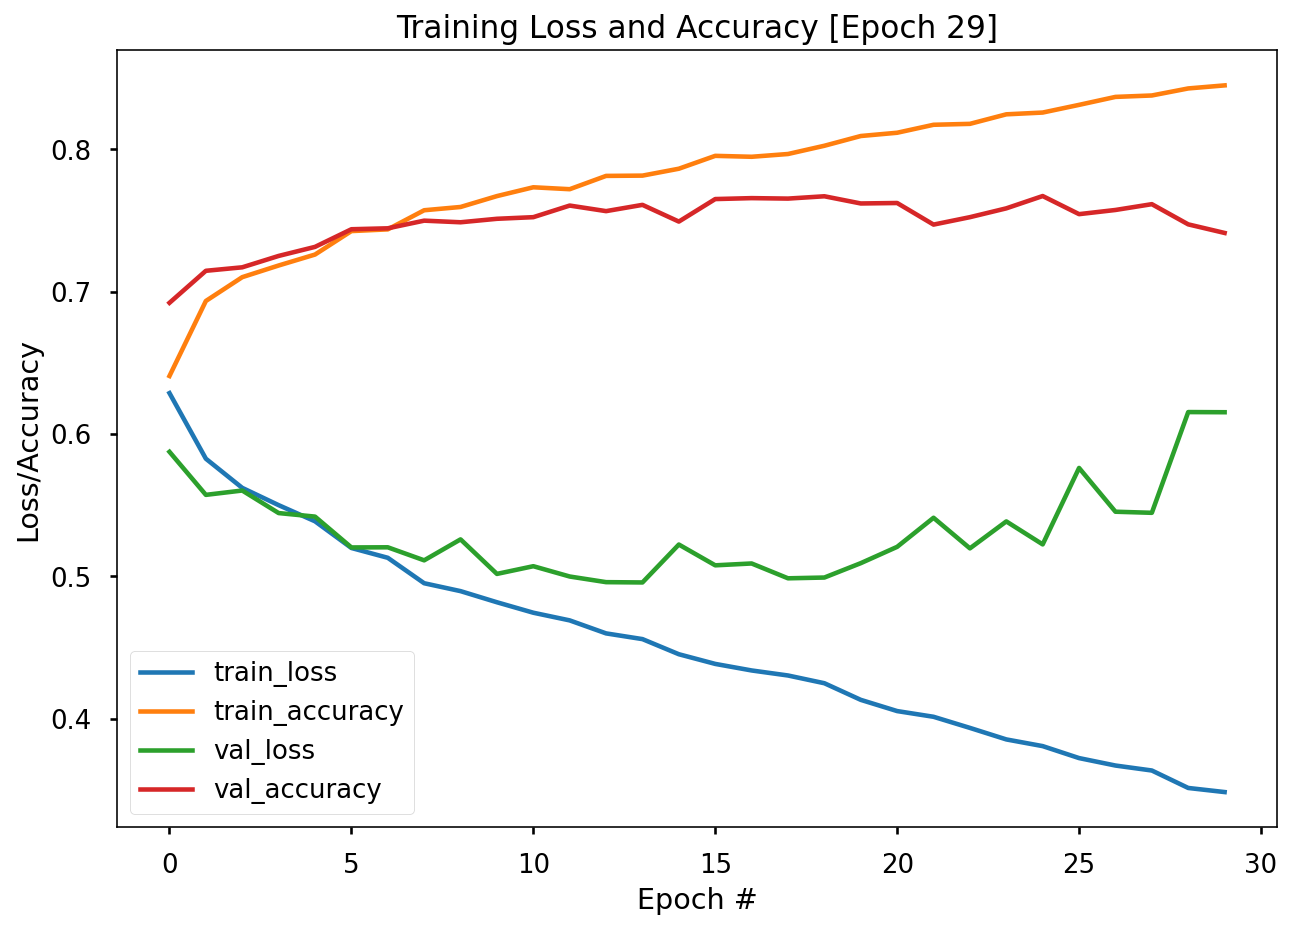

CNN running time is 92.67mins


In [15]:
import time
t1 = time.time()
cnn.fit(x = training_set, validation_data = test_set, epochs = 30, callbacks=[plot_losses])
t2 = time.time()
print('CNN running time is {:.2f}mins'.format((t2 - t1)/60))

From the Loss/Acc vs epoch plot, it seems like models after Epoch 20 are overfitting....
We should adopt the model at about NO.20. The val_accuracy is about 0.74.

##  Testing the CNN's performance on new dataset

### Here is a visual representation of the training samples:
<div>
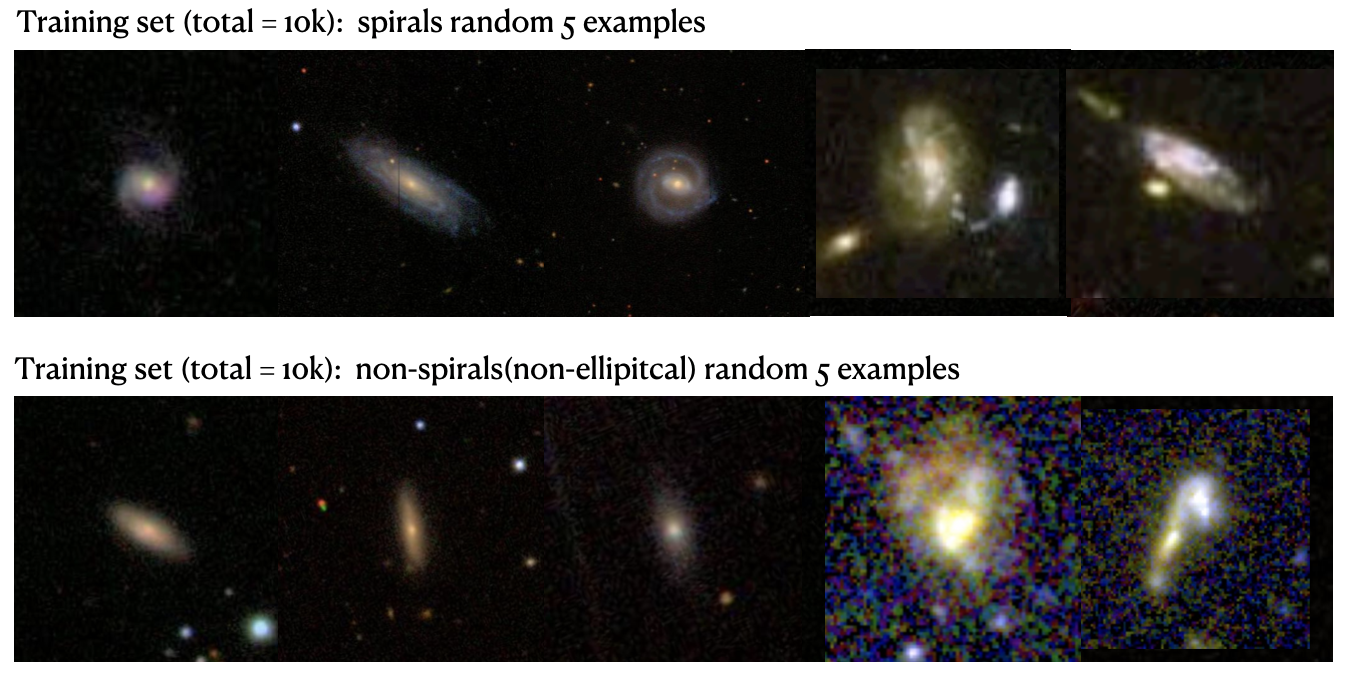
</div>

### We are going to have fun with predicting  
1. A very well-known nearby large spiral galaxy with beautiful rgb color. 
2. A nearby spiral galaxy from a single-band color.
3. An ancient spiral galaxy (2.6 years after the Big Bang) that is gravitationally lensed.
4. A very distant 'cosmic ring of fire' galaxy
5. Some clumpy high-z galaxies

In [16]:
# check which label is which
training_set.class_indices

{'nonspirals': 0, 'spirals': 1}

In [17]:
from keras.preprocessing import image
def image_in(fileloc, dimx=100, dimy=100):
    """ reshape a raw jpg image into an array that is acceptable by keras models.
    Parameters
    ----------
    fileloc : path and name for the input image
        an input directory under which files are searched.
    dimx, dimy : int
        should be the same as the target_size in the trained CNN
    ----------
    Return
    test_image that can be processed by kera models 
    """
    test_image = image.load_img(fileloc, target_size = (dimx, dimy))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    return test_image

### Prediction 1. [on a higher-resolution color image]
This is a beautiful nearby spiral galaxy M101. The image is much large and has more details than the training set. 
Would CNN be able to recognise it as as spiral galaxy ?  Let's see.
<div>
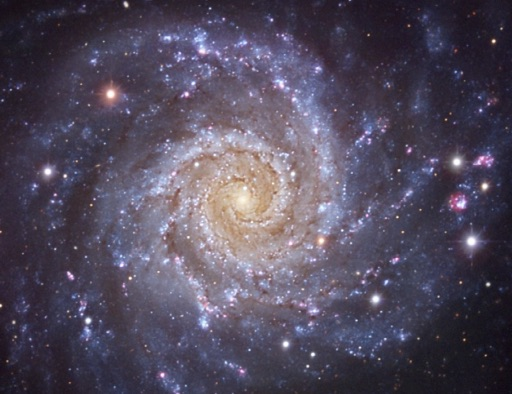
</div>


In [18]:
import numpy as np
fileloc = 'dataset/single_prediction_test/nearby_large.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

print('The predicted label is ', result)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)   

The predicted label is  [[1.]]
CNN predicts that the image above is  a spiral galaxy


### Prediction 2.  [on single-color image]
This is also a nearby spiral galaxy. The image is taken using only one filter,  i.e., a single color image.
Would CNN trained on 3-color images be able to recognise it as as spiral galaxy ?  Let's see.

<div>
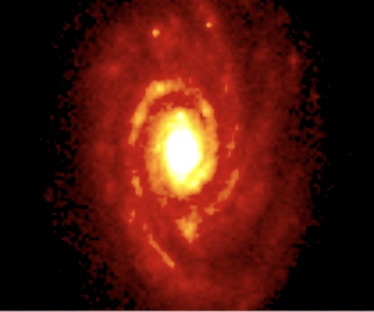
</div>


In [19]:
fileloc = 'dataset/single_prediction_test/spiral_singleband.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

print(result)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)   

[[0.]]
CNN predicts that the image above is  not a spiral galaxy


### Prediction 3.  [on a gravitationally lensed distant spiral image]

This is an ancient spiral galaxy that I studied. Would the CNN trained using 
nearby spiral galaxies be able to identify such a proto-type spiral galaxy ? 
https://en.wikipedia.org/wiki/A1689B11

<div>
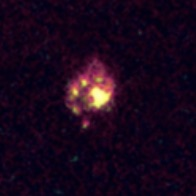
</div>


In [20]:
fileloc = 'dataset/single_prediction_test/ancient_spiral_A1689B11.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

print(result)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)   

[[0.]]
CNN predicts that the image above is  not a spiral galaxy


### Prediction 4:  What about a weird type ? Spiral or non-Spiral ?
This is the cosmic 'ring of fire' galaxy that I discovered. 
https://astronomycommunity.nature.com/posts/a-distant-giant-with-a-ring-on-it

Would the CNN trained using nearby spiral galaxies classify such a ring galaxy as 'spiral' or 'nonspiral'?  I am curious.  Let's see! 
<div>
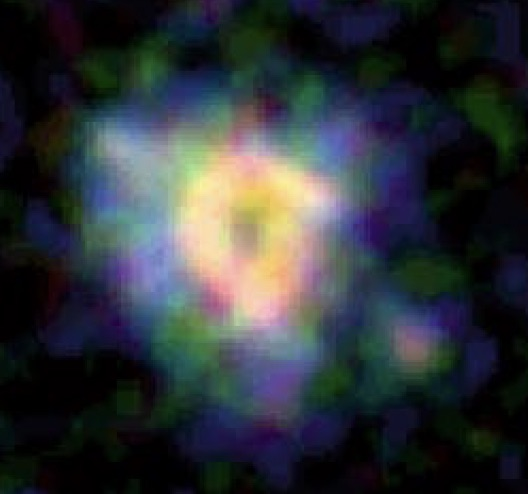
</div>



In [21]:
fileloc = 'dataset/single_prediction_test/cosmic_ring_of_fire.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)   

CNN predicts that the image above is  not a spiral galaxy


### Prediction 5-7:  What about some clumpy high-redshift galaxies like these ? 
[Successfully predict that they are not spirls]
Images from the CANDELS survey:
<div>
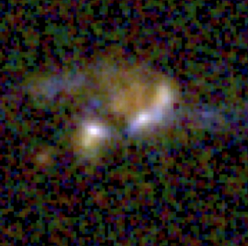
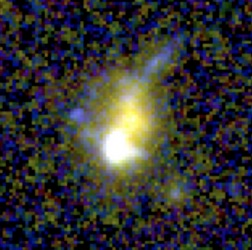
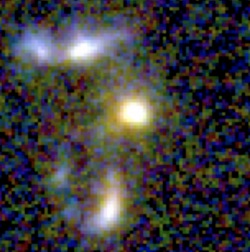
</div>


In [22]:
fileloc = 'dataset/single_prediction_test/clumpy1.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)  

fileloc = 'dataset/single_prediction_test/clumpy2.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)   

fileloc = 'dataset/single_prediction_test/clumpy3.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][0] == 1:
    prediction = 'a spiral galaxy'
else:
    prediction = 'not a spiral galaxy'
    
print('CNN predicts that the image above is ', prediction)   

CNN predicts that the image above is  a spiral galaxy
CNN predicts that the image above is  not a spiral galaxy
CNN predicts that the image above is  not a spiral galaxy


### Conclusion: 
0. This model is overfitting...
TBD: need to use other metrics such as K-fold Cross Validation to gauge the performance.

The next step is to train a 4th model (cnn_spiral_model4) using 3 categories, spiral, nonspiral (non elliptical) and elliptical.

In [23]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
cnn.save('saved_model/cnn_spiral_modelv3b')

INFO:tensorflow:Assets written to: saved_model/cnn_spiral_modelv3b/assets


In [24]:
cnn.save('saved_model/cnn_spiral_modelv3b.h5')